In [684]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve, least_squares
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

## social cost of DSIC mechansim for two player game and various alphas
- social cost = c \cdot x
- show various values of alpha

In [30]:
n      = 2
c1     = 1.
alphas = [2,3,4]
c2s    = np.arange(1, 5, 0.1) 

In [31]:
def getDSICAllo(cs, alpha):
    den = sum([c**(-alpha) for c in cs])
    return cs**(-alpha) / den

In [45]:
xs = []
ws = []
for a in alphas:
    temp1, temp2 = [], []
    for c2 in c2s:
        cs = np.array([c1, c2])

        x = getDSICAllo(cs, alpha=a)
        w = np.dot(x, cs)

        temp1.append(x)
        temp2.append(w)
    xs.append(temp1)
    ws.append(temp2)
xs = np.array(xs)
ws = np.array(ws)
xs.shape, ws.shape

((3, 40, 2), (3, 40))

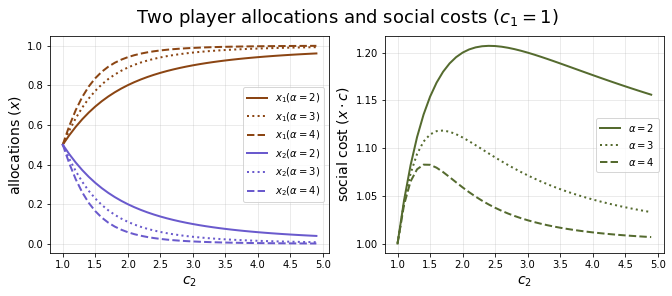

In [116]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,4))

ls = ['-', ':', '--']
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,0], label=r'$x_1 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='saddlebrown', linewidth=2)
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,1], label=r'$x_2 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='slateblue', linewidth=2)

for i, alpha in enumerate(alphas):
    axarr[1].plot(c2s, ws[i,:], label=r'$\alpha={:1d}$'.format(alpha), linestyle=ls[i], 
                  color='darkolivegreen', linewidth=2)
    
for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)
    
axarr[0].set_ylabel(r'allocations ($x$)', size=14)
axarr[1].set_ylabel(r'social cost ($x \cdot c$)', size=14)

f.suptitle(r'Two player allocations and social costs ($c_1=1$)', size=18)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()

## DSIC welfare degredation as n increases
- for 3 values of C, show the rate of social cost degredation as n increase for various values of alpha

In [313]:
alphas = [3,4,5,6,7,8,9,10]
ns     = np.arange(2, 20)

c2res  = []
for i,a in enumerate(alphas):
    temp = []
    for n in ns:
        costs = [1.]
        costs.extend([1.5]*n)
        costs = np.array(costs)

        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        temp.append(w)
    c2res.append(temp)
c2res = np.array(c2res)
c2res.shape

(8, 18)

In [314]:
c3res  = []
for i,a in enumerate(alphas):
    temp = []
    for n in ns:
        costs = [1.]
        costs.extend([2.5]*n)
        costs = np.array(costs)

        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        temp.append(w)
    c3res.append(temp)
c3res = np.array(c3res)
c3res.shape

(8, 18)

In [315]:
c4res  = []
for i,a in enumerate(alphas):
    temp = []
    for n in ns:
        costs = [1.]
        costs.extend([3.5]*n)
        costs = np.array(costs)

        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        temp.append(w)
    c4res.append(temp)
c4res = np.array(c4res)
c4res.shape

(8, 18)

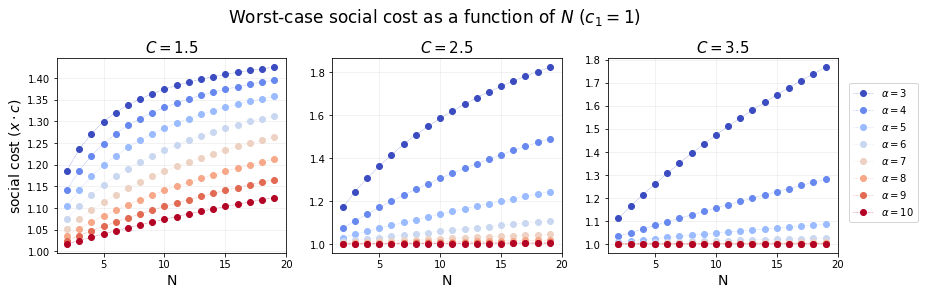

In [316]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

c = np.arange(1, len(alphas)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

plot_handles = []
hline_handles = []
for i,a in enumerate(alphas):
    color = cmap.to_rgba(i+1)
    line, = axarr[0].plot(ns, c2res[i], linewidth=0.5, label=r'$\alpha=${:d}'.format(a), color=color,
                  linestyle='dotted', marker='o', fillstyle='full')
    plot_handles.append(line)
    
    axarr[1].plot(ns, c3res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    axarr[2].plot(ns, c4res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    
    
handles = plot_handles + hline_handles
labels = [h.get_label() for h in handles]

for ax in axarr:
    ax.set_xlabel('N', size=14)
    ax.grid(alpha=0.2)
    ax.set_xticks([5, 10, 15, 20])
#     ax.set_yscale('log')

axarr[-1].legend(handles, labels, bbox_to_anchor=(1.2, 0.9), loc='upper center', ncol=1)

axarr[0].set_ylabel('social cost ($x \cdot c$)', size=14)
axarr[0].set_title(r'$C=1.5$', size=15)
axarr[1].set_title(r'$C=2.5$', size=15)
axarr[2].set_title(r'$C=3.5$', size=15)

f.suptitle(r'Worst-case social cost as a function of $N$ ($c_1=1$)', size=17)
plt.subplots_adjust(top=0.8)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## DSIC size of n to hit different degradation thresholds

In [186]:
cs = np.arange(1.1, 10, 0.01)
ns = np.arange(2, 1000)
a  = 2.

p50s, p75s, p90s, p99s = [],[],[],[]

for c in tqdm(cs):
    for n in ns:
        costs = [1.]
        costs.extend([c]*n)
        costs = np.array(costs)
        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        if w > c * 0.5:
            p50s.append(n)
            break
for c in tqdm(cs):
    for n in ns:
        costs = [1.]
        costs.extend([c]*n)
        costs = np.array(costs)
        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        if w > c * 0.75:
            p75s.append(n)
            break
for c in tqdm(cs):
    for n in ns:
        costs = [1.]
        costs.extend([c]*n)
        costs = np.array(costs)
        x = getDSICAllo(costs, alpha=a)
        w = np.dot(x, costs)
        if w > c * 0.90:
            p90s.append(n)
            break
p50s = np.array(p50s)
p75s = np.array(p75s)
p90s = np.array(p90s)

p50s.shape, p75s.shape, p90s.shape

100%|██████████| 890/890 [00:21<00:00, 41.41it/s]  


((890,), (890,), (890,))

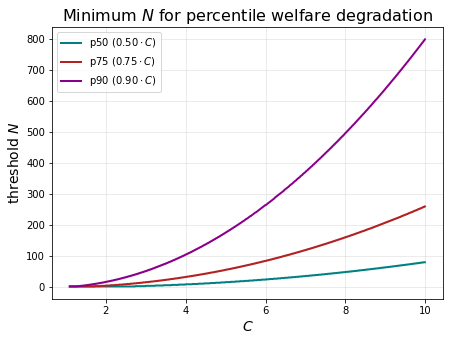

In [205]:
f, ax = plt.subplots(figsize=(7,5))

ax.plot(cs, p50s, linewidth=2, color='teal', label=r'p50 ($0.50 \cdot C$)')
ax.plot(cs, p75s, linewidth=2, color='firebrick', label=r'p75 ($0.75 \cdot C$)')
ax.plot(cs, p90s, linewidth=2, color='darkmagenta', label=r'p90 ($0.90 \cdot C$)')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$C$', size=14)
ax.set_ylabel(r'threshold $N$', size=14)
ax.set_title('Minimum $N$ for percentile welfare degradation', size=16)
ax.legend()

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## social cost of PAB mechansim for two player game and various alphas 
- social cost = \tilde{b} \cdot x
- show various values of alpha

In [490]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [231]:
n      = 2
c1     = 1.
alphas = [3,4,5]
c2s    = np.arange(1, 10, 0.1) 

In [232]:
bs = []
xs = []
ws = []
for a in alphas:
    temp1, temp2, temp3 = [], [], []
    for c2 in c2s:
        cs = np.array([c1, c2])
        b  = getEquilBids(cs, a=a, guess=[c2,c2])

        x = getAllos(b, a=a)
        w = np.dot(x, cs)

        temp1.append(x)
        temp2.append(w)
        temp3.append(b)
    xs.append(temp1)
    ws.append(temp2)
    bs.append(temp3)
xs = np.array(xs)
ws = np.array(ws)
bs = np.array(bs)
xs.shape, ws.shape, bs.shape

((3, 90, 2), (3, 90), (3, 90, 2))

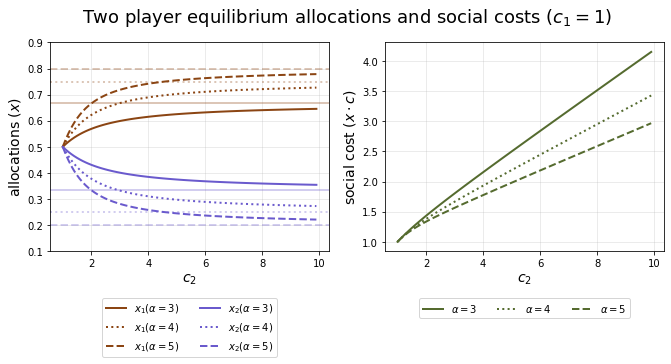

In [250]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,5))

ls = ['-', ':', '--']
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,0], label=r'$x_1 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='saddlebrown', linewidth=2)
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,1], label=r'$x_2 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='slateblue', linewidth=2)
for i, alpha in enumerate(alphas):
    axarr[0].axhline(1-1/alpha, linestyle=ls[i], color='saddlebrown', linewidth=2, alpha=0.3)
    axarr[0].axhline(1/alpha, linestyle=ls[i], color='slateblue', linewidth=2, alpha=0.3)

for i, alpha in enumerate(alphas):
    axarr[1].plot(c2s, ws[i,:], label=r'$\alpha={:1d}$'.format(alpha), linestyle=ls[i], 
                  color='darkolivegreen', linewidth=2)
    
for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)
    
axarr[0].set_ylabel(r'allocations ($x$)', size=14)
axarr[0].set_ylim(0.1,0.9)
axarr[1].set_ylabel(r'social cost ($x \cdot c$)', size=14)

axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

f.subplots_adjust(bottom=0.3)

f.suptitle(r'Two player equilibrium allocations and social costs ($c_1=1$)', size=18)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()

## equil bids and allos of PAB mechansim for two player game and alpha=3

In [286]:
n      = 2
c1     = 1.
a      = 5
c2s    = np.arange(1, 5, 0.1) 

In [287]:
bs = []
xs_equil = []
xs_dsic  = []

for c2 in c2s:
    cs = np.array([c1, c2])
    b  = getEquilBids(cs, a=a, guess=[c2,c2])
    x = getAllos(b, a=a)

    xs_equil.append(x)
    bs.append(b)
    
    xs_dsic.append(getDSICAllo(cs, alpha=a))
    

xs_equil = np.array(xs_equil)
xs_dsic = np.array(xs_dsic)
bs = np.array(bs)
xs_equil.shape, xs_dsic.shape, bs.shape

((40, 2), (40, 2), (40, 2))

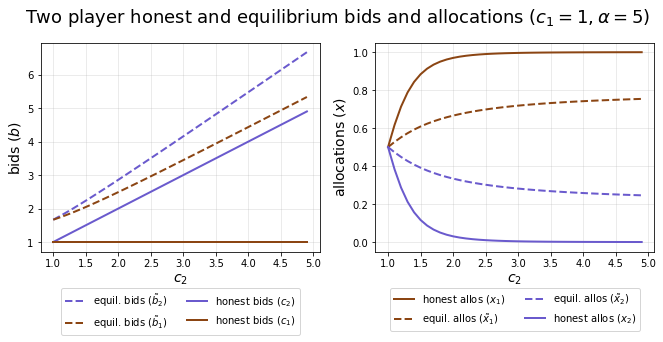

In [289]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,5))

ls = ['-', ':', '--']

axarr[0].plot(c2s, bs[:,1], label=r'equil. bids $(\tilde{b}_2)$', color='slateblue', linewidth=2, 
              linestyle='--')
axarr[0].plot(c2s, bs[:,0], label=r'equil. bids $(\tilde{b}_1)$', color='saddlebrown', linewidth=2, 
              linestyle='--')
axarr[0].plot(c2s, c2s, label=r'honest bids $(c_2)$', color='slateblue', linewidth=2)
axarr[0].plot(c2s, [1]*len(c2s), label=r'honest bids $(c_1)$', color='saddlebrown', linewidth=2)

axarr[1].plot(c2s, xs_dsic[:,0], label=r'honest allos $(x_1)$', color='saddlebrown', linewidth=2, 
              linestyle='-')
axarr[1].plot(c2s, xs_equil[:,0], label=r'equil. allos $(\tilde{x}_1)$', color='saddlebrown', linewidth=2, 
              linestyle='--')
axarr[1].plot(c2s, xs_equil[:,1], label=r'equil. allos $(\tilde{x}_2)$', color='slateblue', linewidth=2, 
              linestyle='--')
axarr[1].plot(c2s, xs_dsic[:,1], label=r'honest allos $(x_2)$', color='slateblue', linewidth=2, 
              linestyle='-')

for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)
    
axarr[0].set_ylabel(r'bids ($b$)', size=14)
axarr[1].set_ylabel(r'allocations ($x$)', size=14)

axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

f.subplots_adjust(bottom=0.3)

f.suptitle(r'Two player honest and equilibrium bids and allocations ($c_1=1,\alpha=5$)', size=18)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()

## equilibrium social cost degradation in n for various alphas

In [304]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [2.9, 3.0, 3.0, 3.0, 2.8, 3.0, 3.0, 2.8]
ns     = np.arange(2, 20)

c2res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([1.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c2res.append(temp)
c2res = np.array(c2res)
c2res.shape

0 3


100%|██████████| 18/18 [00:01<00:00,  9.05it/s]


1 4


100%|██████████| 18/18 [00:02<00:00,  8.83it/s]


2 5


100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


3 6


100%|██████████| 18/18 [00:02<00:00,  8.50it/s]


4 7


100%|██████████| 18/18 [00:02<00:00,  8.11it/s]


5 8


100%|██████████| 18/18 [00:02<00:00,  8.57it/s]


6 9


100%|██████████| 18/18 [00:02<00:00,  8.35it/s]


7 10


100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


(8, 18)

In [306]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [2.9, 3.0, 3.0, 3.0, 2.8, 3.0, 3.0, 2.8]
ns     = np.arange(2, 20)

c3res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([2.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c3res.append(temp)
c3res = np.array(c3res)
c3res.shape

0 3


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


1 4


100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


2 5


100%|██████████| 18/18 [00:02<00:00,  8.89it/s]


3 6


100%|██████████| 18/18 [00:01<00:00,  9.21it/s]


4 7


100%|██████████| 18/18 [00:01<00:00,  9.47it/s]


5 8


100%|██████████| 18/18 [00:01<00:00,  9.47it/s]


6 9


100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


7 10


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


(8, 18)

In [310]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [3.3, 3.0, 3.0, 3.0, 2.8, 3.0, 3.0, 2.8]
ns     = np.arange(2, 20)

c4res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([3.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c4res.append(temp)
c4res = np.array(c4res)
c4res.shape

0 3


100%|██████████| 18/18 [00:01<00:00,  9.42it/s]


1 4


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


2 5


100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


3 6


100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


4 7


100%|██████████| 18/18 [00:01<00:00,  9.40it/s]


5 8


100%|██████████| 18/18 [00:01<00:00,  9.30it/s]


6 9


100%|██████████| 18/18 [00:01<00:00,  9.34it/s]


7 10


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


(8, 18)

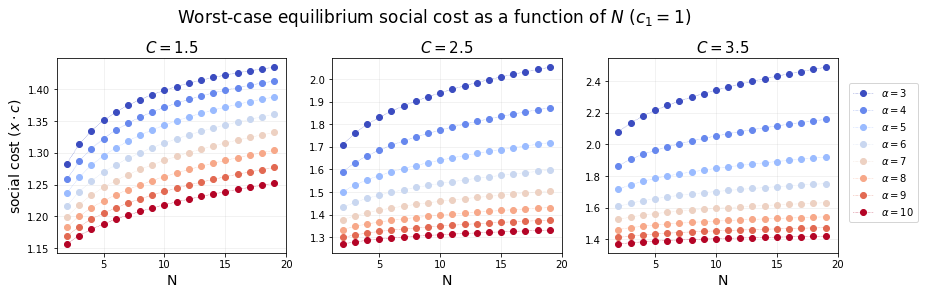

In [312]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

c = np.arange(1, len(alphas)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

plot_handles = []
hline_handles = []
for i,a in enumerate(alphas):
    color = cmap.to_rgba(i+1)
    line, = axarr[0].plot(ns, c2res[i], linewidth=0.5, label=r'$\alpha=${:d}'.format(a), color=color,
                  linestyle='dotted', marker='o', fillstyle='full')
    plot_handles.append(line)
    
    axarr[1].plot(ns, c3res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    axarr[2].plot(ns, c4res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    
    
handles = plot_handles + hline_handles
labels = [h.get_label() for h in handles]

for ax in axarr:
    ax.set_xlabel('N', size=14)
    ax.grid(alpha=0.2)
    ax.set_xticks([5, 10, 15, 20])
#     ax.set_yscale('log')

axarr[-1].legend(handles, labels, bbox_to_anchor=(1.2, 0.9), loc='upper center', ncol=1)

axarr[0].set_ylabel('social cost ($x \cdot c$)', size=14)
axarr[0].set_title(r'$C=1.5$', size=15)
axarr[1].set_title(r'$C=2.5$', size=15)
axarr[2].set_title(r'$C=3.5$', size=15)

f.suptitle(r'Worst-case equilibrium social cost as a function of $N$ ($c_1=1$)', size=17)
plt.subplots_adjust(top=0.8)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## comparing equilibrium and dsic social cost degradation in n for alpha = 3

In [317]:
ns

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])

In [321]:
alpha = 3.

equil_sc = []
dsic_sc  = []

loAnz  = [2.0, 2.0, 2.0]
hiAnz  = [2.9, 3.1, 3.3]

for n in ns:
    temp1, temp2 = [], []
    for i, c in enumerate([1.5, 2.5, 3.5]):
        costs = [1.]
        guess = [loAnz[i]]

        costs.extend([c]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=alpha, guess=guess)
        allos = getAllos(bids, a=alpha)
        temp1.append(np.dot(costs, allos))
        
        h_allos = getAllos(np.array(costs), a=alpha)
        temp2.append(np.dot(np.array(costs), h_allos))
    equil_sc.append(temp1)
    dsic_sc.append(temp2)
equil_sc = np.array(equil_sc)
dsic_sc  = np.array(dsic_sc)

In [323]:
equil_sc.shape, dsic_sc.shape

((18, 3), (18, 3))

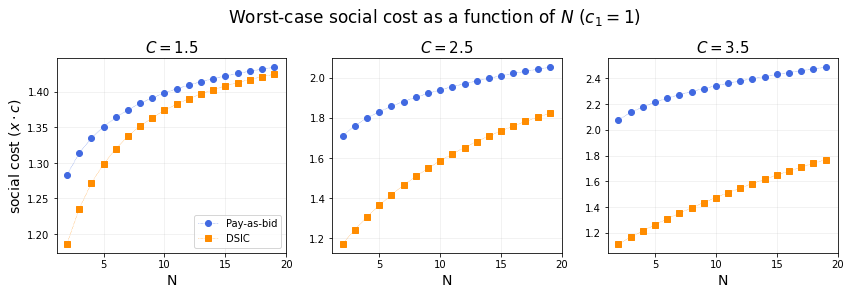

In [345]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

plot_handles = []
hline_handles = []


for i in range(3):
    line1, = axarr[i].plot(ns, equil_sc[:,i], linewidth=0.5, linestyle='dotted', marker='o', fillstyle='full',
                  color='royalblue', label='Pay-as-bid')
    line2, = axarr[i].plot(ns, dsic_sc[:,i], linewidth=0.5, linestyle='dotted', marker='s', fillstyle='full',
                  color='darkorange', label='DSIC')
    if i == 0:
        plot_handles.append(line1)
        plot_handles.append(line2)
        
handles = plot_handles + hline_handles
labels = [h.get_label() for h in handles]


for ax in axarr:
    ax.set_xlabel('N', size=14)
    ax.grid(alpha=0.2)
    ax.set_xticks([5, 10, 15, 20])

# axarr[-1].legend(handles, labels, bbox_to_anchor=(1.21, 0.55), loc='upper center', ncol=1)

axarr[0].legend(loc=4)
axarr[0].set_ylabel('social cost ($x \cdot c$)', size=14)
axarr[0].set_title(r'$C=1.5$', size=15)
axarr[1].set_title(r'$C=2.5$', size=15)
axarr[2].set_title(r'$C=3.5$', size=15)

f.suptitle(r'Worst-case social cost as a function of $N$ ($c_1=1$)', size=17)
plt.subplots_adjust(top=0.8)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## POA as a function of c2 for different N, alpha combinations

In [702]:
alphas = [3,6,9]
c2s   = np.arange(1, 5.01, 0.1)
c2s

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. ])

In [703]:
alphas = [3, 6, 9]
loAnz  = [2.0, 2.0, 1.7]
hiAnz  = [3.3, 3.0, 2.2]

In [704]:
N_ = 3
welfares = [] 
for j, alpha in enumerate(alphas):
    temp = []
    for i, c2 in enumerate(c2s):
        costs   = [1]
        costs.extend([c2]*N_)
        guess   = [loAnz[j]]
        guess.extend([hiAnz[j]]*N_)
        bids    = getEquilBids(costs, a=alpha, guess=guess)
        xTilde  = getAllos(bids, a=alpha)
        temp.append(np.dot(costs, xTilde))
    welfares.append(temp)
welfares = np.asarray(welfares)
welfares.shape

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(3, 41)

In [705]:
alphas = [3, 6, 9]
loAnz  = [2.0, 2.0, 1.7]
hiAnz  = [3.3, 3.0, 2.2]

In [706]:
N_ = 5
welfares5 = [] 
for j, alpha in enumerate(alphas):
    temp = []
    for i, c2 in enumerate(c2s):
        costs   = [1]
        costs.extend([c2]*N_)
        guess   = [loAnz[j]]
        guess.extend([hiAnz[j]]*N_)
        bids    = getEquilBids(costs, a=alpha, guess=guess)
        xTilde  = getAllos(bids, a=alpha)
        temp.append(np.dot(costs, xTilde))
    welfares5.append(temp)
welfares5 = np.asarray(welfares5)
welfares5.shape

(3, 41)

In [707]:
alphas = [3, 6, 9]
loAnz  = [2.0, 2.0, 1.2]
hiAnz  = [2.5, 2.5, 1.7]

In [708]:
N_ = 7
welfares7 = [] 
for j, alpha in enumerate(alphas):
    temp = []
    for i, c2 in enumerate(c2s):
        costs   = [1]
        costs.extend([c2]*N_)
        guess   = [loAnz[j]]
        guess.extend([hiAnz[j]]*N_)
        bids    = getEquilBids(costs, a=alpha, guess=guess)
        xTilde  = getAllos(bids, a=alpha)
        temp.append(np.dot(costs, xTilde))
    welfares7.append(temp)
welfares7 = np.asarray(welfares7)
welfares7.shape

(3, 41)

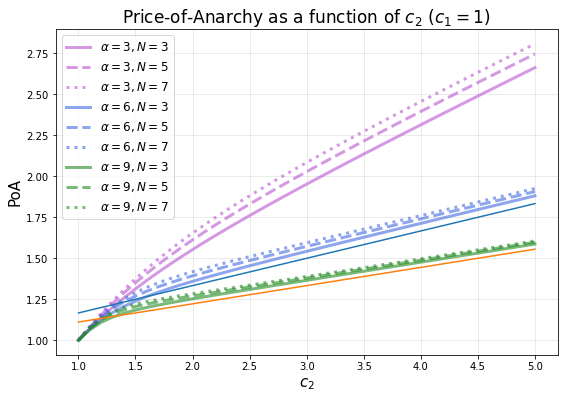

In [711]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['mediumorchid', 'royalblue', 'forestgreen']
for i, alpha in enumerate(alphas):
    ax.plot(c2s, welfares[i,:], linewidth=3, alpha=0.6, 
                  label=r'$\alpha={:d},N=3$'.format(alpha), color=colors[i])
    ax.plot(c2s, welfares5[i,:], linewidth=3, alpha=0.6, 
                  label=r'$\alpha={:d},N=5$'.format(alpha), color=colors[i], linestyle='--')
    ax.plot(c2s, welfares7[i,:], linewidth=3, alpha=0.6, 
                  label=r'$\alpha={:d},N=7$'.format(alpha), color=colors[i], linestyle=':')


# ax.plot(c2s,c2s/2.8+1)
# ax.plot(c2s,c2s/3+1)
ax.plot(c2s,c2s/6+1)
ax.plot(c2s,c2s/9+1)
ax.grid(alpha=0.3)
ax.set_xlabel(r'$c_2$', size=15)
    
ax.legend(prop={'size': 12})

ax.set_ylabel('PoA', size=15)
ax.set_title(r'Price-of-Anarchy as a function of $c_2$ ($c_1=1$)', size=17)
# plt.subplots_adjust(top=0.8)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')

plt.show()

## social cost of tullock mechansim for two-player game and various alphas 
- social cost = \tilde{b} \cdot x
- show various values of alpha

In [491]:
def getEquilBidsTullock(cs, a, f, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**a for bi in bs])
    xs    = [(bi**a)/denom for bi in bs]
    us    = [(f-cs[i])*xs[i]-bs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllosTullock(bids, a):
    denom = sum([b**a for b in bids])
    return np.array(bids**a) / denom

In [678]:

def get_equil_bids_tullock(cs, alpha, f, guess=None, atol=1e-10):
    """
    Compute the unique PNE bids in a Tullock contest with heterogeneous costs.

    Parameters
    ----------
    cs : array-like
        Player-specific costs c_i  (length n, all < f).
    alpha : float  (alpha > 0)
        Contest exponent.
    f : float
        Fixed prize magnitude.
    guess : array-like or None
        Optional starting point for the solver (must be non-negative).
        If None we use 0.5 * (f - c_i) as a safe interior point.
    atol : float
        Absolute tolerance below which a bid is rounded to 0.

    Returns
    -------
    bids : ndarray shape (n,)
        Non-negative equilibrium bids that also give each player u_i ≥ 0.
    """
    cs = np.asarray(cs, dtype=float)
    n = cs.size
    if np.any(cs >= f):
        raise ValueError("Require f > c_i for every i.")

    # ------------------------------------------------------------------
    # 1. Build the symbolic first-order conditions only once.
    # ------------------------------------------------------------------
    bs_syms = sp.symbols(f"b0:{n}")
    denom_sym = sum(b**alpha for b in bs_syms)
    xs_sym = [b**alpha / denom_sym for b in bs_syms]
    us_sym = [(f - cs[i]) * xs_sym[i] - bs_syms[i] for i in range(n)]
    foc_sym = [sp.diff(us_sym[i], bs_syms[i]) for i in range(n)]

    # Lambdify for fast numeric evaluation
    foc_funcs = [sp.lambdify(bs_syms, foc_sym[i], 'numpy') for i in range(n)]
    util_funcs = [sp.lambdify(bs_syms, us_sym[i], 'numpy') for i in range(n)]

    # ------------------------------------------------------------------
    # 2. Residual = [FOCs, negative-utility penalty]
    # ------------------------------------------------------------------
    def residual(bids):
        bids = np.asarray(bids)
        foc_vals = np.array([f(*bids) for f in foc_funcs])
        util_vals = np.array([u(*bids) for u in util_funcs])
        penalty = np.clip(-util_vals, 0, np.inf)   # only if u_i < 0
        return np.concatenate([foc_vals, penalty])

    # ------------------------------------------------------------------
    # 3. Starting point (strictly positive ⇒ easier convergence)
    # ------------------------------------------------------------------
    if guess is None:
        guess = 0.5 * (f - cs)
    guess = np.maximum(guess, 1e-6)

    # ------------------------------------------------------------------
    # 4. Solve ‖residual‖² → 0 subject to bids ≥ 0
    # ------------------------------------------------------------------
    result = least_squares(
        residual,
        x0=guess,
        bounds=(0, np.inf),            # lower bound 0, no upper bound
        ftol=1e-12, xtol=1e-12, gtol=1e-12,
        max_nfev=10000
    )

    if not result.success:
        raise RuntimeError(f"Solver failed: {result.message}")

    bids = result.x
    bids[np.isclose(bids, 0, atol=atol)] = 0.0
    return bids


def get_allos_tullock(bids, alpha):
    """
    Allocation shares x_i for a given bid profile.
    """
    bids = np.asarray(bids, dtype=float)
    denom = np.sum(bids ** alpha)
    if denom == 0:
        return np.zeros_like(bids)
    return bids ** alpha / denom

In [676]:
getEquilBidsTullock(np.array([1.,1.]), a=5, f=6., guess=[5,5])

array([6.25, 6.25])

In [689]:
get_equil_bids_tullock(np.array([1.,1.5]), alpha=5, f=6.)

array([0.30570926, 0.70048285])

In [614]:
f_     = 11
n      = 2
c1     = 1.
alphas = [3,4,5]
c2s    = np.arange(1, 10, 0.1) 

In [589]:
getEquilBidsTullock(np.array([1,9.7]), a=4, f=10., guess=[0.0143, 0.011])

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([0.02364919, 0.00387675])

In [615]:
bs = []
xs = []
ws = []
for a in alphas:
    temp1, temp2, temp3 = [], [], []
    for c2 in c2s:
        cs = np.array([c1, c2])
        if c2 < 5:
            guess = [c2,c2]
        elif c2 < 8:
            guess = [1,0.8]
        elif c2 < 9:
            guess = [0.12,0.05]
        else:
            guess = [0.0144,0.0103]
        b  = getEquilBidsTullock(cs, a=a, f=f_, guess=guess)

        x = getAllosTullock(b, a=a)
        w = np.dot(x, cs)

        temp1.append(x)
        temp2.append(w)
        temp3.append(b)
    xs.append(temp1)
    ws.append(temp2)
    bs.append(temp3)
xs = np.array(xs)
ws = np.array(ws)
bs = np.array(bs)
xs.shape, ws.shape, bs.shape

((3, 90, 2), (3, 90), (3, 90, 2))

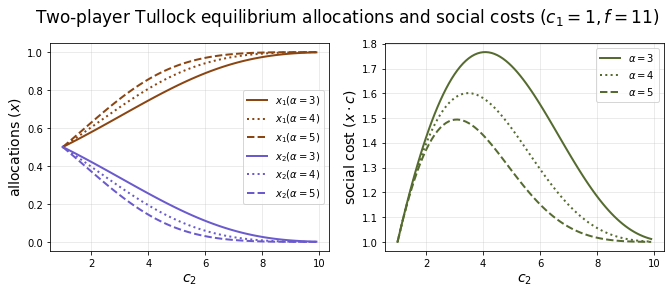

In [616]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,5))

ls = ['-', ':', '--']
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,0], label=r'$x_1 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='saddlebrown', linewidth=2)
for i, alpha in enumerate(alphas):
    axarr[0].plot(c2s, xs[i,:,1], label=r'$x_2 (\alpha={:1d})$'.format(alpha), linestyle=ls[i], 
                  color='slateblue', linewidth=2)

for i, alpha in enumerate(alphas):
    axarr[1].plot(c2s, ws[i,:], label=r'$\alpha={:1d}$'.format(alpha), linestyle=ls[i], 
                  color='darkolivegreen', linewidth=2)
    
for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)
    
axarr[0].set_ylabel(r'allocations ($x$)', size=14)
# axarr[0].set_ylim(0.1,0.9)
axarr[1].set_ylabel(r'social cost ($x \cdot c$)', size=14)

# axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
# axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

f.subplots_adjust(bottom=0.3)

f.suptitle(r'Two-player Tullock equilibrium allocations and social costs ($c_1=1, f=11$)', size=17)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()

In [700]:
cs = np.array([4,2])
bs = getEquilBidsTullock(
    cs, a=1, f=5., guess=[1,0.5]
)
xs = getAllosTullock(bs, a=2)
bs, xs, np.dot(cs, xs)

(array([1.8432, 1.3824]), array([0.64, 0.36]), 1.3600000000019006)

## equil bids and allos of tullock mechansim for two player game and alpha=5

In [617]:
n      = 2
c1     = 1.
a      = 5.
f_     = 6.
c2s    = np.arange(1, 5, 0.1) 

In [621]:
bs = []
xs_equil = []
xs_dsic  = []
xs_tull  = []
bs_tull  = []

for c2 in c2s:
    cs = np.array([c1, c2])
    b  = getEquilBids(cs, a=a, guess=[c2,c2])
    x = getAllos(b, a=a)

    xs_equil.append(x)
    bs.append(b)
    
    xs_dsic.append(getDSICAllo(cs, alpha=a))
    
    b  = getEquilBidsTullock(cs, a=a, f=f_, guess=[f_-c2,f_-c2])
    xs_tull.append(getAllosTullock(b, a=a))
    bs_tull.append(b)


xs_equil = np.array(xs_equil)
xs_dsic  = np.array(xs_dsic)
xs_tull  = np.array(xs_tull)
bs       = np.array(bs)
bs_tull  = np.array(bs_tull)
xs_equil.shape, xs_dsic.shape, xs_tull.shape, bs.shape

((40, 2), (40, 2), (40, 2), (40, 2))

In [675]:
getEquilBidsTullock(np.array([1.,1.]), a=5, f=6., guess=[5,5])

array([6.25, 6.25])

In [669]:
bs_tull[0]

array([6.25, 6.25])

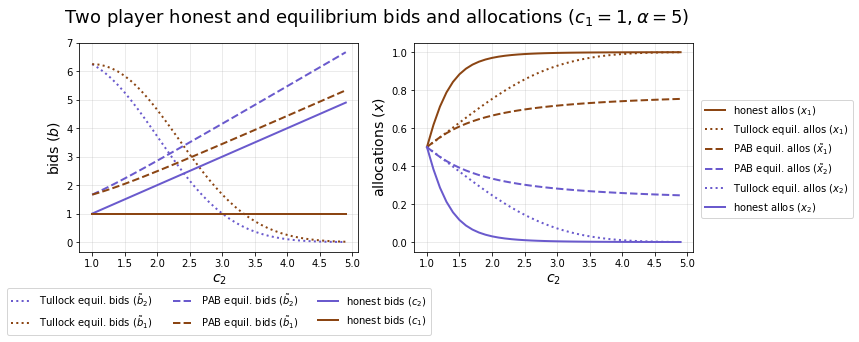

In [634]:
f, axarr = plt.subplots(ncols = 2, figsize=(11,5))

ls = ['-', ':', '--']


axarr[0].plot(c2s, bs_tull[:,1], label=r'Tullock equil. bids $(\tilde{b}_2)$', color='slateblue', linewidth=2, 
              linestyle=':')
axarr[0].plot(c2s, bs_tull[:,0], label=r'Tullock equil. bids $(\tilde{b}_1)$', color='saddlebrown', linewidth=2, 
              linestyle=':')

axarr[0].plot(c2s, bs[:,1], label=r'PAB equil. bids $(\tilde{b}_2)$', color='slateblue', linewidth=2, 
              linestyle='--')
axarr[0].plot(c2s, bs[:,0], label=r'PAB equil. bids $(\tilde{b}_1)$', color='saddlebrown', linewidth=2, 
              linestyle='--')
axarr[0].plot(c2s, c2s, label=r'honest bids $(c_2)$', color='slateblue', linewidth=2)
axarr[0].plot(c2s, [1]*len(c2s), label=r'honest bids $(c_1)$', color='saddlebrown', linewidth=2)

axarr[1].plot(c2s, xs_dsic[:,0], label=r'honest allos $(x_1)$', color='saddlebrown', linewidth=2, 
              linestyle='-')
axarr[1].plot(c2s, xs_tull[:,0], label=r'Tullock equil. allos $(x_1)$', color='saddlebrown', linewidth=2, 
              linestyle=':')
axarr[1].plot(c2s, xs_equil[:,0], label=r'PAB equil. allos $(\tilde{x}_1)$', color='saddlebrown', linewidth=2, 
              linestyle='--')
axarr[1].plot(c2s, xs_equil[:,1], label=r'PAB equil. allos $(\tilde{x}_2)$', color='slateblue', linewidth=2, 
              linestyle='--')
axarr[1].plot(c2s, xs_tull[:,1], label=r'Tullock equil. allos $(x_2)$', color='slateblue', linewidth=2, 
              linestyle=':')
axarr[1].plot(c2s, xs_dsic[:,1], label=r'honest allos $(x_2)$', color='slateblue', linewidth=2, 
              linestyle='-')

for ax in axarr:
    ax.legend()
    ax.set_xlabel(r'$c_2$', size=14)
    ax.grid(alpha=0.3)
    
axarr[0].set_ylabel(r'bids ($b$)', size=14)
axarr[1].set_ylabel(r'allocations ($x$)', size=14)

axarr[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
axarr[1].legend(loc='upper center', bbox_to_anchor=(1.3, 0.75), ncol=1)

f.subplots_adjust(bottom=0.3)

f.suptitle(r'Two player honest and equilibrium bids and allocations ($c_1=1,\alpha=5$)', size=18)
plt.savefig('out.png', facecolor='white', dpi=200, bbox_inches='tight')
plt.show()

# PoA in between plot

In [789]:
alpha = 4
c2s   = np.arange(1.5, 2.51, 0.1)
c2s

array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

In [790]:
N_ = 4
welfares4 = [] 
for i, c2 in enumerate(c2s):
    costs   = [1]
    costs.extend([c2]*N_)
    
    guess   = [3.]
    guess.extend([5.]*N_)

    bids    = getEquilBids(costs, a=alpha, guess=guess)
    xTilde  = getAllos(bids, a=alpha)
    welfares4.append(np.dot(costs, xTilde))

welfares4 = np.asarray(welfares4)
welfares4.shape

(11,)

In [791]:
N_ = 16
welfares16 = [] 
for i, c2 in enumerate(c2s):
    costs   = [1.]
    costs.extend([c2]*N_)
    
    guess   = [2.]
    guess.extend([5.]*N_)

    bids    = getEquilBids(costs, a=alpha, guess=guess)
    xTilde  = getAllos(bids, a=alpha)
    welfares16.append(np.dot(costs, xTilde))

welfares16 = np.asarray(welfares16)
welfares16.shape

(11,)

In [792]:
N_ = 64
welfares64 = [] 
for i, c2 in enumerate(c2s):
# for i, c2 in [(0, 4.)]:
    costs   = [1.]
    costs.extend([c2]*N_)
    
    guess   = [1.]
    guess.extend([2.]*N_)

    bids    = getEquilBids(costs, a=alpha, guess=guess)
    print(bids)
    xTilde  = getAllos(bids, a=alpha)
    welfares64.append(np.dot(costs, xTilde))

welfares64 = np.asarray(welfares64)
welfares64.shape

[1.36663303 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928
 2.00989928 2.00989928 2.00989928 2.00989928 2.00989928]
[1.37558968 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473
 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473
 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473
 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473 2.14370473
 2.14

(11,)

In [800]:
N_ = 128
welfares128 = [] 
for i, c2 in enumerate(c2s):
# for i, c2 in [(0, 4.)]:
    costs   = [1.]
    costs.extend([c2]*N_)
    
    guess   = [1.]
    guess.extend([2.]*N_)

    bids    = getEquilBids(costs, a=alpha, guess=guess)
    print(bids)
    xTilde  = getAllos(bids, a=alpha)
    welfares128.append(np.dot(costs, xTilde))

welfares128 = np.asarray(welfares128)
welfares128.shape

[1.35042462 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868
 2.00506868 2.00506868 2.00506868 2.00506868 2.00506868 2.0050

[1.39309216 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047
 2.80652047 2.80652047 2.80652047 2.80652047 2.80652047 2.8065

(11,)

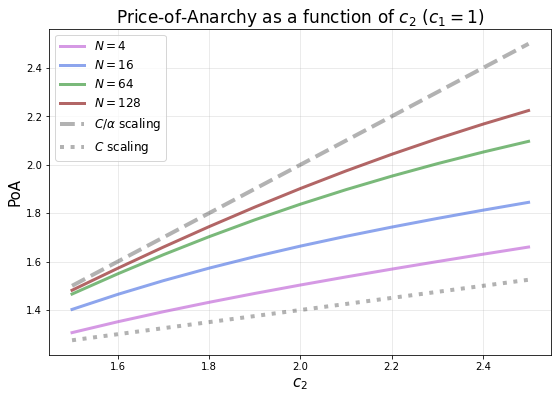

In [804]:
f, ax = plt.subplots(figsize=(9,6))

colors = ['mediumorchid', 'royalblue', 'forestgreen', 'maroon']

ax.plot(c2s, welfares4, linewidth=3, alpha=0.6, label=r'$N=4$', color=colors[0])
ax.plot(c2s, welfares16, linewidth=3, alpha=0.6, label=r'$N=16$', color=colors[1])
ax.plot(c2s, welfares64, linewidth=3, alpha=0.6, label=r'$N=64$', color=colors[2])
ax.plot(c2s, welfares128, linewidth=3, alpha=0.6, label=r'$N=128$', color=colors[3])
    

ax.plot(c2s,c2s, linewidth=4, alpha=0.3, color='k', linestyle='--', label=r'$C/\alpha$ scaling')
ax.plot(c2s,c2s/4+0.9, linewidth=4, alpha=0.3, color='k', linestyle=':', label=r'$C$ scaling')

ax.grid(alpha=0.3)
ax.set_xlabel(r'$c_2$', size=15)
    
ax.legend(prop={'size': 12})

ax.set_ylabel('PoA', size=15)
ax.set_title(r'Price-of-Anarchy as a function of $c_2$ ($c_1=1$)', size=17)
# plt.subplots_adjust(top=0.8)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')

plt.show()

## Tullock equilibrium social cost degradation in n for various alphas

In [ ]:
getEquilBidsTullock(costs, a=a, f=f_, guess=guess)

In [651]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [1.8, 1.8, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [1.2, 1.2, 1.8, 1.8, 1.7, 1.6, 1.4, 1.4]
ns     = np.arange(2, 20)
f_     = 2.

c2res  = []
# for i,a in enumerate(alphas):
for i,a in [(0,3)]:
    temp = []
    print(i, a)
#     for n in tqdm(ns):
    for n in [3]:
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([1.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBidsTullock(costs, a=a, f=f_, guess=guess)
        allos = getAllosTullock(bids, a=a)
        print(bids,allos,np.dot(costs, allos))

        temp.append(np.dot(costs, allos))
    c2res.append(temp)
c2res = np.array(c2res)
c2res.shape

0 3
[0.98388426 0.87438855 0.87438856 0.87438856] [0.32198553 0.22600482 0.22600483 0.22600482] 1.339007235153589


(1, 1)

In [306]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [2.9, 3.0, 3.0, 3.0, 2.8, 3.0, 3.0, 2.8]
ns     = np.arange(2, 20)

c3res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([2.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c3res.append(temp)
c3res = np.array(c3res)
c3res.shape

0 3


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


1 4


100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


2 5


100%|██████████| 18/18 [00:02<00:00,  8.89it/s]


3 6


100%|██████████| 18/18 [00:01<00:00,  9.21it/s]


4 7


100%|██████████| 18/18 [00:01<00:00,  9.47it/s]


5 8


100%|██████████| 18/18 [00:01<00:00,  9.47it/s]


6 9


100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


7 10


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


(8, 18)

In [310]:
alphas = [3,   4,   5,   6,   7,   8,   9,   10]
loAnz  = [2.0, 2.0, 2.0, 1.7, 1.7, 1.7, 1.8, 1.8]
hiAnz  = [3.3, 3.0, 3.0, 3.0, 2.8, 3.0, 3.0, 2.8]
ns     = np.arange(2, 20)

c4res  = []
for i,a in enumerate(alphas):
    temp = []
    print(i, a)
    for n in tqdm(ns):
        costs = [1]
        guess = [loAnz[i]]
        
        costs.extend([3.5]*n)
        guess.extend([hiAnz[i]]*n)

        bids  = getEquilBids(costs, a=a, guess=guess)
        allos = getAllos(bids, a=a)

        temp.append(np.dot(costs, allos))
    c4res.append(temp)
c4res = np.array(c4res)
c4res.shape

0 3


100%|██████████| 18/18 [00:01<00:00,  9.42it/s]


1 4


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


2 5


100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


3 6


100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


4 7


100%|██████████| 18/18 [00:01<00:00,  9.40it/s]


5 8


100%|██████████| 18/18 [00:01<00:00,  9.30it/s]


6 9


100%|██████████| 18/18 [00:01<00:00,  9.34it/s]


7 10


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


(8, 18)

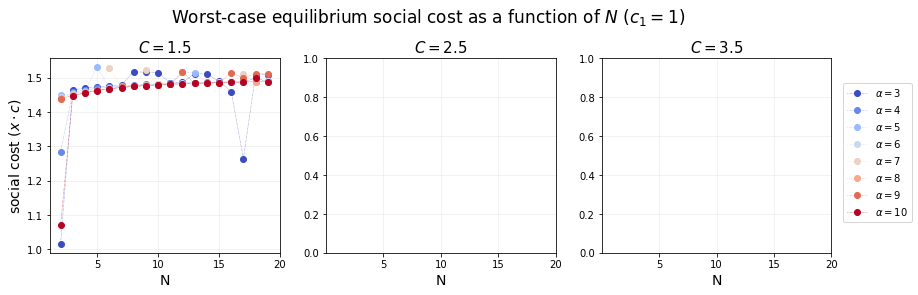

In [636]:
f, axarr = plt.subplots(ncols=3, figsize=(14, 4))

c = np.arange(1, len(alphas)+1)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
cmap.set_array([])

plot_handles = []
hline_handles = []
for i,a in enumerate(alphas):
    color = cmap.to_rgba(i+1)
    line, = axarr[0].plot(ns, c2res[i], linewidth=0.5, label=r'$\alpha=${:d}'.format(a), color=color,
                  linestyle='dotted', marker='o', fillstyle='full')
    plot_handles.append(line)
    
#     axarr[1].plot(ns, c3res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
#     axarr[2].plot(ns, c4res[i], linewidth=0.5, color=color, linestyle='dotted', marker='o', fillstyle='full')
    
    
handles = plot_handles + hline_handles
labels = [h.get_label() for h in handles]

for ax in axarr:
    ax.set_xlabel('N', size=14)
    ax.grid(alpha=0.2)
    ax.set_xticks([5, 10, 15, 20])
#     ax.set_yscale('log')

axarr[-1].legend(handles, labels, bbox_to_anchor=(1.2, 0.9), loc='upper center', ncol=1)

axarr[0].set_ylabel('social cost ($x \cdot c$)', size=14)
axarr[0].set_title(r'$C=1.5$', size=15)
axarr[1].set_title(r'$C=2.5$', size=15)
axarr[2].set_title(r'$C=3.5$', size=15)

f.suptitle(r'Worst-case equilibrium social cost as a function of $N$ ($c_1=1$)', size=17)
plt.subplots_adjust(top=0.8)
plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [667]:
cs = np.array([1,2.5,2.5,2.5])
bs = getEquilBidsTullock(
    cs, a=3, f=3., guess=[1.9, 0.5, 0.5, 0.5]
)
xs = getAllosTullock(bs, a=3)
bs, xs, np.dot(cs, xs)

(array([0.13684673, 0.32935025, 0.32935025, 0.32935025]),
 array([0.02335316, 0.32554895, 0.32554895, 0.32554895]),
 2.4649702612662105)